<a href="https://colab.research.google.com/github/abdullahArshadCheema/Artifical_Neural_Network_Model/blob/main/Transfer%20Learning%20on%20Cifar-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Unzip Folder**

In [ ]:
import tarfile

In [ ]:
File_path = "drive/MyDrive/ANN_Datasets/cifar-10-python.tar.gz"
Folder = "drive/MyDrive/ANN_Datasets/cifar_data/"

In [ ]:
file = tarfile.open(File_path)
file.extractall(Folder)
file.close()

# **Preprocessing Cifar-10 Data**

In [ ]:
import numpy as np
import pickle
import os

In [ ]:
file_path = Folder + "cifar-10-batches-py/"
flist = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4',
         'data_batch_5', 'test_batch', 'batches.meta']

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        fo.close()
    return dict

In [ ]:
def convert_train(n_data, n_dim):

  X = []
  y = []

  for i in range(0, len(flist)-2):
    batch_n = file_path + flist[i]
    temp = unpickle(batch_n)
    for image in temp[b'data']:
      image_data = np.array(image)
      image_data = np.dstack((image_data[:1024], image_data[1024:2048], image_data[2048:])) 
      image_data = image_data.reshape(32, 32, 3)
      X.append(image_data)

    y.append(temp[b'labels'])
  
  return np.array(X), np.array(y).astype('uint8')

def load_data():
  metadata = unpickle(file_path + flist[-1])
  n_data = metadata[b'num_cases_per_batch']
  n_dim = metadata[b'num_vis']

  train, test = {}, {}
  train['X'], y_temp = convert_train(n_data, n_dim)
  train['y'] = y_temp.reshape(-1, 1)
  
  test_data = unpickle(file_path + flist[-2])

  test_X = []
  for image in test_data[b'data']:
    image_data = np.array(image)
    image_data = np.dstack((image_data[:1024], image_data[1024:2048], image_data[2048:]))
    image_data = image_data.reshape(32, 32, 3)
    test_X.append(image_data)
  
  test['X'] = np.array(test_X)
  test['y'] = (np.array(test_data[b'labels']).astype('uint8')).reshape(-1, 1)

  return train, test

def create_data():
  train, test = load_data()
  return train['X'], train['y'], test['X'], test['y']

In [ ]:
X, y, X_test, y_test = create_data()

In [ ]:
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

!pip install -U git+https://github.com/qubvel/efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-deqxdf2a
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-deqxdf2a
     |████████████████████████████████| 50 kB 3.2 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=4d368221fb8ca94a9cc22184f81734470579bc41776f610567e829c467d097ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-2_5gc2lp/wheels/4f/5d/1a/f5568d40de3899e676981cbe16009738bab99940f320f402b5
Successfully built efficientnet


# **Model Creation**

In [ ]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as enet

In [ ]:
#converting class vectors to binary class matrices
num_classes = 10

y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
X = X.astype('float32')
X_test = X_test.astype('float32')
X /= 255
X_test /= 255

In [ ]:
base_model_1 = enet.EfficientNetB0(include_top = False, input_shape=(32,32,3), weights='imagenet')

x = base_model_1.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)
x = Dense(64, activation=tf.nn.relu)(x)
predications = Dense(10, activation=tf.nn.softmax)(x)

model_final_1 = Model(inputs = base_model_1.input, outputs = predications)
model_final_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 16, 16, 32)   864         ['input_3[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 16, 16, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 16, 16, 32)   0           ['stem_bn[0][0]']                
                                                                                            

In [ ]:
model_final_1.compile(loss = 'categorical_crossentropy',
                      optimizer=Adam(0.0001),
                      metrics=['accuracy'])

history = model_final_1.fit(X, y,
                  batch_size=128,
                  epochs=10,
                  validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 490s 1s/step - loss: 2.9052 - accuracy: 0.2126 - val_loss: 1.6809 - val_accuracy: 0.4228
Epoch 2/10
391/391 [==============================] - 479s 1s/step - loss: 1.8020 - accuracy: 0.4165 - val_loss: 1.3085 - val_accuracy: 0.5483
Epoch 3/10
391/391 [==============================] - 477s 1s/step - loss: 1.4182 - accuracy: 0.5258 - val_loss: 1.1217 - val_accuracy: 0.6173
Epoch 4/10
391/391 [==============================] - 479s 1s/step - loss: 1.1895 - accuracy: 0.5957 - val_loss: 0.9813 - val_accuracy: 0.6619
Epoch 5/10
391/391 [==============================] - 479s 1s/step - loss: 1.0319 - accuracy: 0.6500 - val_loss: 0.8834 - val_accuracy: 0.6924
Epoch 6/10
391/391 [==============================] - 478s 1s/step - loss: 0.9167 - accuracy: 0.6862 - val_loss: 0.8164 - val_accuracy: 0.7169
Epoch 7/10
391/391 [==============================] - 477s 1s/step - loss: 0.8343 - accuracy: 0.7151 - val_loss: 0.7614 - val_accuracy: 0.7347

In [ ]:
import math
score = model_final_1.evaluate(X_test, y_test, steps=math.ceil(10000/32))
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

313/313 [==============================] - 23s 73ms/step - loss: 0.6689 - accuracy: 0.7720
Test Loss:  0.6689416766166687
Test Accuracy:  0.7720000147819519


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Accuracy Curves')

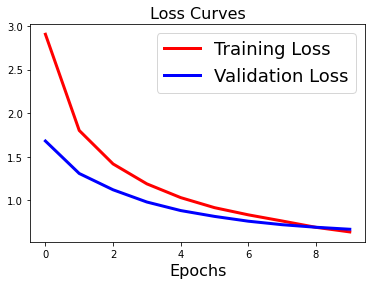

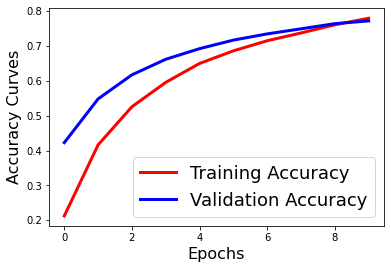

In [ ]:

# Loss Curves
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.title('Loss Curves', fontsize=16)


#Accuracy Curves
plt.figure()
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy Curves', fontsize=16)

In [ ]:
from keras.applications import MobileNet
from keras.layers import Input,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D,MaxPooling2D,RandomFlip,RandomZoom,RandomRotation

base_model_2 = MobileNet(include_top = False, weights='imagenet', input_shape=(32, 32, 3), classes=y.shape)
model = Sequential()
model.add(base_model_2)
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(128, activation=('relu')))
model.add(Dropout(0.3))
model.add(Dense(64, activation=('relu')))
model.add(Dropout(0.2))
model.add(Dense(10, activation=('softmax')))
# model.summary()

# base_model_2 = Xception(include_top = False, input_shape=(224,224,3), weights='imagenet')
# base_model_2.trainable = False
# data_augmentation = Sequential(
#     [RandomFlip("horizontal"), 
#      RandomRotation(0.1),
#      RandomZoom(0.1)]
# )

# x = base_model_2.output
# x = Flatten()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.7)(x)
# x = Dense(64, activation=tf.nn.relu)(x)
# predications = Dense(10, activation=tf.nn.softmax)(x)

# model_final_2 = Model(inputs = base_model_2.input, outputs = predications)
# model_final_2.summary()


# inputs = tf.keras.Input(shape=(32, 32, 3))
# x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224)))(inputs)
# # x = tf.keras.applications.xception.preprocess_input(x)
# x = base_model_2(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# outputs = tf.keras.layers.Dense(10, activation=('softmax'))(x)
# model = tf.keras.Model(inputs, outputs)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
input_shape = X.shape
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (50000, 1, 1, 1024)       3228864   
_________________________________________________________________
module_wrapper_1 (ModuleWrap (50000, 1, 1, 1024)       0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (50000, 1024)             0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (50000, 128)              131200    
_________________________________________________________________
module_wrapper_4 (ModuleWrap (50000, 128)              0         
_________________________________________________________________
module_wrapper_5 (ModuleWrap (50000, 64)               8256      
_________________________________________________________________
module_wrapper_6 (ModuleWrap (50000, 64)               0

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
history = model.fit(X, y, batch_size=128, validation_data=(X_test, y_test), epochs=epochs, verbose=1)

Epoch 1/10
391/391 [==============================] - 533s 1s/step - loss: 1.4417 - accuracy: 0.5214 - val_loss: 0.9357 - val_accuracy: 0.6983
Epoch 2/10
391/391 [==============================] - 532s 1s/step - loss: 0.8693 - accuracy: 0.7278 - val_loss: 0.8486 - val_accuracy: 0.7207
Epoch 3/10
391/391 [==============================] - 540s 1s/step - loss: 0.6989 - accuracy: 0.7825 - val_loss: 0.6922 - val_accuracy: 0.7742
Epoch 4/10
391/391 [==============================] - 529s 1s/step - loss: 0.6097 - accuracy: 0.8112 - val_loss: 0.7904 - val_accuracy: 0.7480
Epoch 5/10
391/391 [==============================] - 530s 1s/step - loss: 0.5385 - accuracy: 0.8333 - val_loss: 0.7371 - val_accuracy: 0.7645
Epoch 6/10
391/391 [==============================] - 526s 1s/step - loss: 0.4898 - accuracy: 0.8506 - val_loss: 0.7049 - val_accuracy: 0.7791
Epoch 7/10
391/391 [==============================] - 525s 1s/step - loss: 0.4535 - accuracy: 0.8595 - val_loss: 0.7045 - val_accuracy: 0.7808

In [ ]:
import math
score = model.evaluate(X_test, y_test, steps=math.ceil(10000/32))
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

313/313 [==============================] - 12s 38ms/step - loss: 0.8386 - accuracy: 0.7794
Test Loss:  0.8386303782463074
Test Accuracy:  0.7793999910354614


Text(0, 0.5, 'Accuracy Curves')

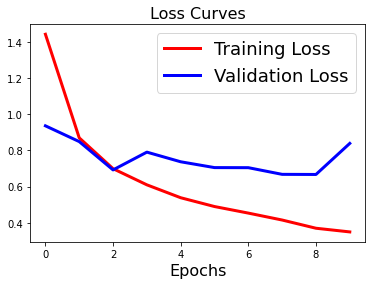

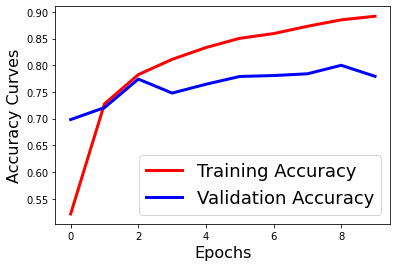

In [ ]:
# Loss Curves
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.title('Loss Curves', fontsize=16)


#Accuracy Curves
plt.figure()
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy Curves', fontsize=16)